In [1]:
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def open_risk_free_yields():
    df = pd.read_csv('risk_free_yields.csv')
    df["date"] = df.apply(lambda row: datetime.strptime(row["date"], "%Y-%m-%d"), axis=1)
    return df

def open_issuance_data():
    df = pd.read_csv('issuance_data.csv')
    return df

def get_filenames_without_extension_os(directory_path):
    filenames_without_ext = []
    for filename_with_ext in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename_with_ext)):
            name, ext = os.path.splitext(filename_with_ext)
            filenames_without_ext.append(name)
    return filenames_without_ext

In [3]:
risk_free_yields = open_risk_free_yields()
issuance_data = open_issuance_data()

In [4]:
files =  get_filenames_without_extension_os('./trade_data')


In [60]:
trades_dict = dict.fromkeys(files, "")
meta_dict = dict.fromkeys(files, "")

In [6]:
def get_risk_free_yield(start_date, to_maturity):
    items = risk_free_yields['date'].to_numpy()
    closest_date = nearest_date(items, start_date)
    periods = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 7.0, 10.0, 15.0]
    closest_period = get_closest_period(to_maturity, periods)
    column_name = get_col_name(closest_period)
    row = risk_free_yields.loc[risk_free_yields['date'] == closest_date]
    return row[column_name].values[0]

def get_col_name(period):
    return 'period_' + str(period)

def get_closest_period(value, periods):
    result = min(periods, key=lambda x: abs(x - value))
    return result

def nearest_date(items, pivot):
    return min([i for i in items if i <= pivot], key=lambda x: abs(x - pivot))

In [7]:
def calculate_ytm(row, coupon):
    face_value = 100
    present_value = row["ohlc4"]
    avg = (face_value + present_value) / 2
    t = row["toMaturity"]
    ytm = (coupon + (face_value - present_value) / t) / avg
    return ytm * 100

In [8]:
def process_trade_data(meta):
    name = meta["Название"].values[0]
    df = pd.read_csv('./trade_data/' + name + '.csv', dtype={'<DATE>': object})
    df["ohlc4"] = ( df["<CLOSE>"] + df["<OPEN>"] + df["<HIGH>"] + df["<LOW>"] ) / 4
    df["date"] = df.apply(lambda row: datetime.strptime(str(row["<DATE>"]), "%d%m%y"), axis=1)
    df["dateEnd"] = df.apply(lambda row: datetime.strptime(meta["dateEnd"].values[0], "%Y-%m-%d"), axis=1)
    df["toMaturity"] = df.apply(lambda row: (row["dateEnd"] - row["date"]).days / 365, axis=1)
    df["risk_free_yield"] = df.apply(lambda row: get_risk_free_yield(row["date"], row["toMaturity"]), axis=1)
    df["ytm"] = df.apply(lambda row: calculate_ytm(row, meta["effYield"]), axis=1)
    df["premium"] = df["ytm"] - df["risk_free_yield"]
    return df


In [ ]:
for key in meta_dict.keys():
    meta_dict[key] = issuance_data[ issuance_data["Название"] == key]

In [63]:
for key in trades_dict.keys():
    trades_dict[key] = process_trade_data(meta_dict[key])

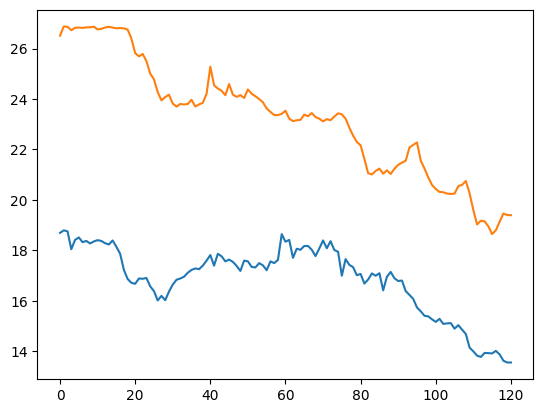

In [66]:
plt.plot(trades_dict["ГТЛК 2P-07"]["risk_free_yield"])
plt.plot(trades_dict["ГТЛК 2P-07"]["ytm"])

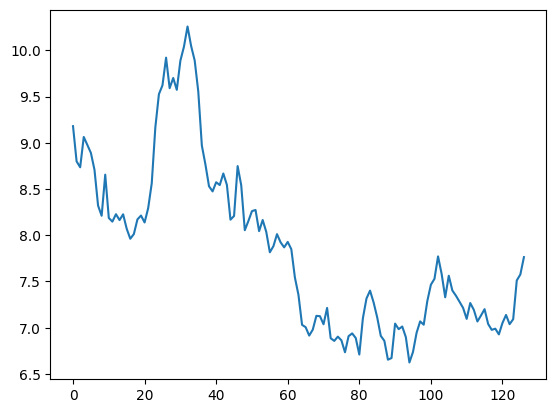

In [80]:
plt.plot(trades_dict['ПАО ЛК Европлан 001P-09']["premium"])

In [68]:
average_premium = np.zeros(30)

In [ ]:
for i in range(30):
    premium = 0
    tickers = len(trades_dict)
    for key in trades_dict:
        local_premium = trades_dict[key].iloc[i]["premium"]
        premium += local_premium / tickers
    average_premium[i] = premium

7.820893304181407
5.070706551474206
7.94181465589595
9.179604791660932
2.802397097626077
8.084901610688789
4.389131734352105
8.147761053870884
8.798567642757021
2.724639209751256
8.108720577499934
4.3262670509650825
8.328787661699565
8.734829046281202
2.5065638513470603
8.68657926288676
4.0963764141786
8.606281132370704
9.062646491642703
2.775582090613291
8.412141754109491
3.8356393647122253
8.730618318102092
8.97692496575701
3.028343291118585
8.322369104728562
4.106263813318254
8.602518677656487
8.889472139102534
3.404518192723076
8.49802810350894
3.8551247869760132
9.0242194536285
8.707474909886436
3.5791960150633777
8.468557020200969
3.7597010605248684
9.089200234755026
8.320245741802129
3.2547011464106443
8.574752031390542
3.521778915792435
9.811867821607443
8.210505129255989
3.297754602984927
8.515394859789918
3.3564162372291335
10.238210987910808
8.655026458102668
2.9098805770986687
8.357962963084525
3.761070367236144
10.372960567029637
8.18652799358076
3.122140837782906
8.410649

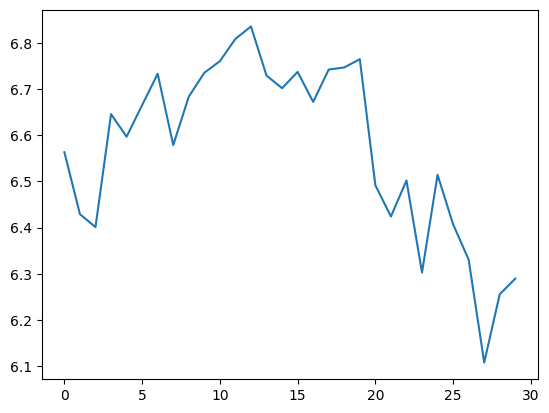

In [70]:
plt.plot(average_premium)

[[],
 0      2.802397
 1      2.724639
 2      2.506564
 3      2.775582
 4      3.028343
          ...   
 104    0.966852
 105    1.165935
 106    1.417869
 107    1.525938
 108    1.456589
 Name: premium, Length: 109, dtype: float64,
 0      2.802397
 1      2.724639
 2      2.506564
 3      2.775582
 4      3.028343
          ...   
 104    0.966852
 105    1.165935
 106    1.417869
 107    1.525938
 108    1.456589
 Name: premium, Length: 109, dtype: float64,
 0      2.802397
 1      2.724639
 2      2.506564
 3      2.775582
 4      3.028343
          ...   
 104    0.966852
 105    1.165935
 106    1.417869
 107    1.525938
 108    1.456589
 Name: premium, Length: 109, dtype: float64,
 0      2.802397
 1      2.724639
 2      2.506564
 3      2.775582
 4      3.028343
          ...   
 104    0.966852
 105    1.165935
 106    1.417869
 107    1.525938
 108    1.456589
 Name: premium, Length: 109, dtype: float64,
 0      2.802397
 1      2.724639
 2      2.506564
 3      2.775582